# Recommendation_Engine

In [472]:
import pandas as pd
import numpy as np
import datapreprocessing as dp
from collections import Counter

# sklearn Packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Loading gensim and nltk libraries
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dimitriwilhelm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Explorative Data Analysis (EDA)

In [2]:
df_Apps=dp.getDF("Apps_for_Android_5.json")

In [3]:
df_Apps = df_Apps[:10000]

### Reformat 'reviewTime' into a datetime

In [5]:
df_Apps.reviewTime = pd.to_datetime(df_Apps.reviewTime)

In [6]:
df_Apps.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]","Loves the song, so he really couldn't wait to ...",3.0,Really cute,1383350400,2013-11-02
1,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5.0,2-year-old loves it,1323043200,2011-12-05
2,A1SXASF6GYG96I,B004A9SDD8,Barbara Gibbs,"[0, 0]",I found this at a perfect time since my daught...,5.0,Fun game,1337558400,2012-05-21
3,A2B54P9ZDYH167,B004A9SDD8,"Brooke Greenstreet ""Babylove""","[3, 4]",My 1 year old goes back to this game over and ...,5.0,We love our Monkeys!,1354752000,2012-12-06
4,AFOFZDTX5UC6D,B004A9SDD8,C. Galindo,"[1, 1]",There are three different versions of the song...,5.0,This is my granddaughters favorite app on my K...,1391212800,2014-02-01


### Filtering

In [7]:
df_Apps.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [8]:
reviews = df_Apps['asin'].groupby(df_Apps['asin']).count()
print('Number of reviews for each product: {}'.format(reviews))

Number of reviews for each product: asin
B004A9SDD8     17
B004AFQAUA     62
B004AHBBPW     96
B004ALVL6W     95
B004AMAIZQ      7
B004AMDC86      7
B004ANC00Q     63
B004ANE2WU      6
B004ANMWPY    244
B004AZH4C8     86
B004AZSY4K     53
B004BN3YQE     76
B004C4FL5Y     24
B004CN7Y4G     13
B004DJXQDC      5
B004DKSUXC     11
B004DLLNFS     17
B004DLNBDA     76
B004DLNC4I    380
B004DLPXAO    571
B004DLTS4G      6
B004DLUS4A     17
B004DLUSD6     19
B004DLYJCC     17
B004DLZBU6     33
B004DM0UII    122
B004DM0X8U     18
B004DM0X9O     36
B004DM1OAQ    355
B004DM1ZG4     14
             ... 
B004GL88GW     65
B004GLI2GS      9
B004GMJKTK    283
B004GMP53U     86
B004GMP8AU      5
B004GMT14Y    327
B004GR1Q38     44
B004GT9ET4     44
B004GVUPFE     69
B004GVV4T0    144
B004GVYJCE     30
B004GVYXTS    482
B004GW0EW2      8
B004GWRMWC    189
B004GY8NTQ     42
B004GYCF7W     96
B004GYNPL2     58
B004GYOQ6A     47
B004GYVYV0    122
B004GYY714    563
B004GYYQLA     99
B004GZHRR4      5
B004H

In [9]:
reviews_sorted = reviews.sort_values(ascending=False)
print('Top 10 reviewed products: \n')
print('{}'.format(reviews_sorted.head(10)))

Top 10 reviewed products: 

asin
B004FOA84A    582
B004DLPXAO    571
B004GYY714    563
B004DPCSKI    484
B004GVYXTS    482
B004DLNC4I    380
B004DM1OAQ    355
B004DPIEF6    355
B004EBZX6W    348
B004FRX0MY    328
Name: asin, dtype: int64


In [10]:
reviews_sorted = reviews.sort_values(ascending=True)
print('Bottom 10 reviewed products: \n')
print('{}'.format(reviews_sorted.head(10)))

Bottom 10 reviewed products: 

asin
B004FKH6MG    5
B004E32A1Q    5
B004H3H3VA    5
B004H2TZTO    5
B004FG2SKU    5
B004FFLJ8I    5
B004GZHRR4    5
B004EVRBJ4    5
B004H6SKWS    5
B004GMP8AU    5
Name: asin, dtype: int64


## DataPreProcessing

We will perform the following steps:
- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.

- Words that have fewer than 3 characters are removed.

- All stopwords are removed.

- Words are lemmatized - words in third person changed to first person and verbs in past and future tenses are changed into present.

- Words are stemmed - words are reduced to their root form.


In [519]:
# Write a function to perform lemmatize and stem preprocessing steps on data set.

# Define our Porter stemmer:
ps = PorterStemmer()

# The idea of stemming is to shorten the lookup and normalize sentences.
# Many variations of words carry the same meaning, 
# other than when tense is involved.

def lemmatize_stemming(text):
    return ps.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

love


In [520]:
# Select a review text to preview after preprocessing.

review_sample = df_Apps.reviewText[1]
words = []
for word in review_sample.split(' '):
    words.append(word)


print(words)
print(preprocess(review_sample))

['Oh,', 'how', 'my', 'little', 'grandson', 'loves', 'this', 'app.', "He's", 'always', 'asking', 'for', '"Monkey."', 'Grandma', 'has', 'tired', 'of', 'it', 'long', 'before', 'he', 'has.', 'Finding', 'the', 'items', 'on', 'each', 'page', 'that', 'he', 'can', 'touch', 'and', 'activate', 'is', 'endlessly', 'entertaining', 'for', 'him,', 'at', 'least', 'for', 'now.', 'Well', 'worth', 'the', '$.99.']
['littl', 'grandson', 'love', 'ask', 'monkey', 'grandma', 'tire', 'long', 'find', 'item', 'page', 'touch', 'activ', 'endlessli', 'entertain', 'worth']


In [522]:
processed_reviews = df_Apps.reviewText.map(preprocess)
processed_reviews[:10]

0    [love, song, couldn, wait, play, littl, intere...
1    [littl, grandson, love, ask, monkey, grandma, ...
2    [perfect, time, daughter, favorit, song, momen...
3    [year, go, game, simpl, easi, toddler, catch, ...
4    [differ, version, song, game, keep, occupi, cl...
5    [cute, great, littl, one, love, think, funni, ...
6    [watch, great, grandson, day, week, hard, mont...
7    [wild, crazi, littl, one, love, sing, song, li...
8    [love, love, love, go, differ, app, come, exci...
9    [cute, alot, item, awesom, say, differ, voic, ...
Name: reviewText, dtype: object

Bag of Words on the Data_set

Create a dictionary from "processed_reviews" containing the number of times a word appears in the training_set

In [532]:
dictionary = gensim.corpora.Dictionary(processed_reviews)

print(dictionary)
count = 0
for k, v in dictionary.iteritems():
    print(k,v)
    count += 1
    if count > 10:
        break

Dictionary(8757 unique tokens: ['child', 'couldn', 'cute', 'game', 'interest']...)
0 child
1 couldn
2 cute
3 game
4 interest
5 like
6 littl
7 long
8 love
9 older
10 play


Gensim filter_extremes

Filter out tokens that appear in 
- less then 15 reviews (absolute number) or
- more than 0.5 reviews
- after the above two steps, keep only the first 100 most frequent tokens.

In [536]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100)
print(dictionary)

Dictionary(100 unique tokens: ['game', 'interest', 'like', 'littl', 'love']...)


In [222]:
reviews = df_Apps.reviewText

clean_reviewData = []
for rev in reviews:
    clean_reviewData.append(" ".join(dp.data_clean(rev)))

pd.DataFrame(clean_reviewData).head()

,0
0,love song realli wait play littl less interest...
1,oh littl grandson love app alway ask monkey gr...
2,found perfect time sinc daughter favorit song ...
3,year old goe back game simpl easi toddler use ...
4,three differ version song game keep occupi eve...


In [223]:
Most_used_Words_reviews = pd.Series(" ".join(clean_reviewData).split()).value_counts()
Most_used_Words_reviews.head()

app     7034
game    5126
use     3151
like    3036
play    2910
dtype: int64

# Modelling

### Classification/Sentiment Analysis using Logistic Regression

In [11]:
df_Apps['pos_neg_rating'] = [1 if x > 3 else 0 for x in df_Apps['overall']]
df_Apps.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,pos_neg_rating
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]","Loves the song, so he really couldn't wait to ...",3.0,Really cute,1383350400,2013-11-02,0
1,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5.0,2-year-old loves it,1323043200,2011-12-05,1
2,A1SXASF6GYG96I,B004A9SDD8,Barbara Gibbs,"[0, 0]",I found this at a perfect time since my daught...,5.0,Fun game,1337558400,2012-05-21,1
3,A2B54P9ZDYH167,B004A9SDD8,"Brooke Greenstreet ""Babylove""","[3, 4]",My 1 year old goes back to this game over and ...,5.0,We love our Monkeys!,1354752000,2012-12-06,1
4,AFOFZDTX5UC6D,B004A9SDD8,C. Galindo,"[1, 1]",There are three different versions of the song...,5.0,This is my granddaughters favorite app on my K...,1391212800,2014-02-01,1


In [167]:
X = df_Apps.reviewText
y = df_Apps.pos_neg_rating

### Train/Test Split

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2) 

In [169]:
print('Train_data set size: {}'.format(X_train.shape[0]))
print('Train_target set size: {}'.format(y_train.shape[0]))
print('Test set size: {}'.format(X_test.shape[0]))

Train_data set size: 8000
Train_target set size: 8000
Test set size: 2000


### CountVectorizer

In [170]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)

In [171]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [172]:
cv_scores = cross_val_score(LogisticRegression(), X_train, y_train, cv = 5)

In [173]:
print('mean cv_accuracy: {}'.format(np.mean(cv_scores)))

mean cv_accuracy: 0.8322499999999999


In [174]:
X_test = vectorizer.transform(X_test)
print('Train set Accuracy: {}'.format(log_reg.score(X_train, y_train)))
print('Test set Accuracy: {}'.format(log_reg.score(X_test, y_test)))

Train set Accuracy: 0.9685
Test set Accuracy: 0.824


## Classification Report

### Report includes precision, recall and f1-score

In [175]:
target_name = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_name))

             precision    recall  f1-score   support

    class 0       0.70      0.63      0.66       548
    class 1       0.86      0.90      0.88      1452

avg / total       0.82      0.82      0.82      2000



### confusion matrix allows us to look at the particular misclassified examples.

In [176]:
cm = confusion_matrix(y_test, log_reg.predict(X_test))

In [177]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [178]:
cm_normalized

array([[0.62773723, 0.37226277],
       [0.10192837, 0.89807163]])

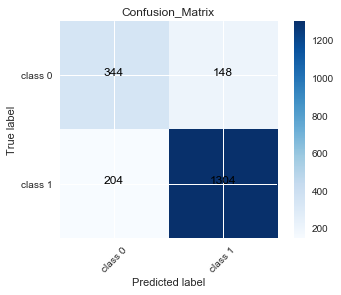

In [179]:
cm = pd.DataFrame(cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion_Matrix')
plt.colorbar()
tick_marks = np.arange(len(target_name))
plt.xticks(tick_marks, target_name, rotation=45)
plt.yticks(tick_marks, target_name)


for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(i, j, cm.iloc[i, j],
            horizontalalignment="center",
            color="black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

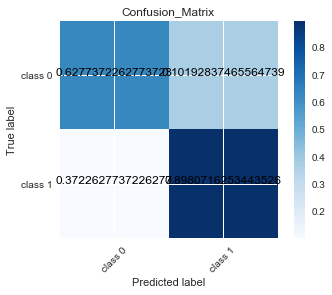

In [180]:
cm_normalized = pd.DataFrame(cm_normalized)
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion_Matrix')
plt.colorbar()
tick_marks = np.arange(len(target_name))
plt.xticks(tick_marks, target_name, rotation=45)
plt.yticks(tick_marks, target_name)

#format(cm[i, j], fmt)

for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(i, j, cm_normalized.iloc[i, j],
            horizontalalignment="center",
            color="black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Clustering and Topic Modeling

### Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation

### CountVectorizer and Tf-idf

TF-IDF stands for "Term Frequency, Inverse Document Frequency". It is a way to score the importance of words in a document based on how frequently they appear across multiple documents.

Intuively:
- If a word appears frequently in a document, it's important. Give the word a high score.
- If a word appears in many documents, it's not a unique identifier. Give the word a low score.

That's why, common words like "the" and "for", which appear in many documents, will be scaled down. Words that appear frequently in a single document will be scaled up.

In [405]:
X_review = df_Apps.reviewText

In [430]:
# Use tf_idf vectorizer for NMF
print('Extracting tf-idf features for NMF')
tfidf_vectorizer = TfidfVectorizer(stop_words=stops)
tfidf = vectorizer.fit_transform(X_review)
tfidf_feature_names = vectorizer.get_feature_names() 
print('Number of total features: {}'.format(len(tfidf_feature_names)))

Extracting tf-idf features for NMF
Number of total features: 14717


In [443]:
tf_vectorizer = CountVectorizer(stop_words=stops)
tf = tf_vectorizer.fit_transform(X_review)
tf_feature_names = tf_vectorizer.get_feature_names()

print('Number of total features: {}'.format(len(tf_feature_names)))

Number of total features: 14575


### Nonnegative Matrix Factorization (NMF) - Term frequency (tf)

In [423]:
### We use NMF for topic extraction

In [424]:
# Initialize NMF
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5)

In [425]:
n_top_words = 15

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #{}:".format(topic_idx), end='\n')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]), end='\n\n')
    print()

In [432]:
nmf_tf = nmf.fit(tf)
nmf_1 = nmf_tf.transform(tf)
#Counter([np.argmax(i) for i in nmf_])

In [446]:
# Output is a list of topics
print("\nTopics in NMF model:")
print_top_words(nmf_tf, tf_feature_names, n_top_words)


Topics in NMF model:
Topic #0:
java nuts ca literary jail youtube kids formerly sort dolby door records thrie jerks doubts

Topic #1:
gather police g2 timeminimal jail polygon grab gb groundbreaking mac chapters andriod literary entity wagon

Topic #2:


IndexError: list index out of range

### Term frequency-inverse document frequency (tfidf)

In [435]:
nmf_tfidf = nmf.fit(tfidf)
nmf_2 = nmf_tfidf.transform(tfidf)

In [436]:
print_top_words(nmf_tfidf, tfidf_feature_names, n_top_words)

Topic #0:
it not but like is would just for so do does really that its don

Topic #1:
game play fun this is playing good games great love challenging and like enjoy very

Topic #2:
you your if can get or will are like want to have what need don

Topic #3:
to easy use have play and able very be time find when it way want

Topic #4:
the of that in and are to is as one on all there for but

Topic #5:
my on kindle phone fire have books and tablet works read can love android with

Topic #6:
app this is for great and love very free good use amazon really recommend works

Topic #7:
quot said and words ghost ghosts then app word weird amp first creepy up so

Topic #8:
was and it my said got this me had then when were we so in

Topic #9:
radio stations listen music local station to can favorite from world tunein love all scanner




# LDA

Topic modeling is a type of statistical modeling for discovering the "topics" that accdour in a collection of decuments. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

In [447]:
# Initialize LDA
lda = LatentDirichletAllocation(n_topics=10, max_iter=5, 
                                learning_method='online',
                               learning_offset=50.,
                               random_state=0)

In [448]:
lda_tf = lda.fit(tf)

/Users/dimitriwilhelm/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [449]:
lda_ = lda_tf.transform(tf)

In [453]:
print("\nTopics in LDA model:")
print_top_words(lda_tf, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0:
tic toe audible tac wallpaper halloween child younger definitions trigger pumpkins bats register os teacher

Topic #1:
moon router twitter signals facebook phases streams seesmic ha routers train born bills strongest image

Topic #2:
wordpress fitness dropbox hortatory property zombie xx meet mainly married college hike artichoke hp zillow

Topic #3:
game play fun like games good time great playing love get really one would graphics

Topic #4:
ghost ghosts room radar house creepy dot dog showed funny sister occupied freaked omg haunted

Topic #5:
said strength totally came red copy cause scared went bible dots dad friends wireless book

Topic #6:
smartphone grandson monkey pounds sold helping cd grandkids mazes exercises spoken beware member mfp servings

Topic #7:
radio listen local scanner tunein police listening diet tracks manager sucks turned tracker pandora ups

Topic #8:
app like use great kindle get one love would works fire free time easy really